In [83]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
import tangent_boundaries as tb
from math import pi
from scipy.sparse import csr_matrix, csc_matrix, linalg as sla

sigma_0 = np.array([[1,0],[0,1]])
sigma_x = np.array([[0,1],[1,0]])
sigma_y = np.array([[0,-1j],[1j,0]])
sigma_z = np.array([[1,0],[0,-1]])

In [143]:
# Let us put it all together neatly

def generate_quarter_stadium_indent(r,L,pos,width,npoints=1000000, plot_shape = False):
    'Generates the set of points in the grid closest to a stadium and the angle of the normal vector.'
    theta = np.linspace(0, pi/2, npoints, endpoint = False)
    sign_theta = 2*np.heaviside(theta-pi,0)-1
    x1 = r*np.cos(theta)
    x2 = np.linspace(0,-L,npoints)
    x3 = np.ones(npoints)*(-L)
    x4 = np.linspace(-L,r, npoints)
    x = np.concatenate((x1,x2,x3,x4))#-np.ones(4*npoints)*(r-L)

    y1 = r*np.sin(theta)
    y2 = np.ones(npoints)*r
    y3 = np.linspace(r,0,npoints)
    y4 = np.zeros(npoints)
    y = np.concatenate((y1,y2,y3,y4))
    
    angles1 = theta
    angles2 = np.ones(npoints)*(pi/2)
    angles3 = np.ones(npoints)*pi
    angles4 = np.ones(npoints)*(3*pi/2)
    angles = np.concatenate((angles1,angles2,angles3,angles4))
       
    z = np.exp(1j*angles)

    boundary_points, indices = np.unique(np.round(np.stack((x, y))), axis = 1, return_inverse=True)


    polar_angle = np.arctan2(boundary_points[1]-np.ones(len(boundary_points[1]))*(r/2)*0.1,boundary_points[0])
    boundary_points = boundary_points[:,np.argsort(polar_angle)]


    # Calculate the sum of elements in z that correspond to the same value in mask
    sums_real = np.bincount(indices, weights=z.real)
    sums_imag = np.bincount(indices, weights=z.imag)
    
    # Calculate the count of elements in b that correspond to the same value in mask
    counts = np.bincount(indices)
    
    # Calculate the average of elements in b that correspond to the same value in mask
    normal_angles = np.angle((sums_real + 1j*sums_imag)/counts)
    normal_angles = normal_angles[np.argsort(polar_angle)]

    second_displacements = np.roll(boundary_points,1,axis = 1)+np.roll(boundary_points,-1,axis = 1)-2*boundary_points #This is like a discrete second derivative.
    in_or_out = second_displacements[0]*np.cos(normal_angles) + second_displacements[1]*np.sin(normal_angles)

    #Get rid of points that are actually fully inside
    boundary_points = boundary_points[:,np.argwhere(in_or_out<=0.1).flatten()]
    normal_angles = normal_angles[np.argwhere(in_or_out<=0.1).flatten()]

    ##repeat to get rid of points that are fully outside
    second_displacements = np.roll(boundary_points,1,axis = 1)+np.roll(boundary_points,-1,axis = 1)-2*boundary_points #This is like a discrete second derivative.
    in_or_out = second_displacements[0]*np.cos(normal_angles) + second_displacements[1]*np.sin(normal_angles) #Scalar product with the normal
    boundary_points = boundary_points[:,np.argwhere(in_or_out>=-1).flatten()]
    normal_angles = normal_angles[np.argwhere(in_or_out>=-1).flatten()]

    # Now let's add the indentation.
    if width<2:
        raise NameError('width must be an integer larger than 1')
    if pos+2*width>=2*L:
        raise NameError('pos+width too large')
    
    if pos+width+1<L:
        conditionx = np.logical_and(boundary_points[0]<-int(pos), boundary_points[0]>-int(pos+width))
        conditionx_corner = np.logical_or(boundary_points[0]==-int(pos), boundary_points[0]==-int(pos+width))
        condition = np.logical_and(conditionx,boundary_points[1]>r/2)
        condition_corner = np.logical_and(conditionx_corner,boundary_points[1]>r/2)
        
        #Lift indentation
        boundary_points[1] = np.where(condition,boundary_points[1]-(r//2)*np.ones(len(boundary_points[1])),boundary_points[1])
        boundary_points[1] = np.where(condition_corner,boundary_points[1]-(r//2-1)*np.ones(len(boundary_points[1])),boundary_points[1])
        normal_angles = np.where(np.logical_and(boundary_points[0]==-int(pos),boundary_points[1]>r/2),pi*np.ones(len(normal_angles)),normal_angles)
        normal_angles = np.where(np.logical_and(boundary_points[0]==-int(pos+width),boundary_points[1]>r/2),0*np.ones(len(normal_angles)),normal_angles)
        #Add sides
        side1 = np.stack(((-int(pos+width))*np.ones(r-1-r//2),np.linspace(r-1,r//2+1,num = r-1-r//2)))
        side2 = np.stack(((-int(pos))*np.ones(r-1-r//2),np.linspace(r-1,r//2+1,num = r-1-r//2)))
        boundary_points = np.concatenate((boundary_points,side1,side2),axis = 1)
                
        
    else:
        conditionx = np.logical_and(boundary_points[0]>int(-2*L+pos+width+3), boundary_points[0]<int(-2*L+pos+2*width+3))
        conditionx_corner = np.logical_or(boundary_points[0]==int(-2*L+pos+width+3), boundary_points[0]==int(-2*L+pos+2*width+3))
        condition = np.logical_and(conditionx,boundary_points[1]<r/2)
        condition_corner = np.logical_and(conditionx_corner,boundary_points[1]<r/2)
        
        #Lift indentation
        boundary_points[1] = np.where(condition,boundary_points[1]+(r//2)*np.ones(len(boundary_points[1])),boundary_points[1])
        boundary_points[1] = np.where(condition_corner,boundary_points[1]+(r//2-1)*np.ones(len(boundary_points[1])),boundary_points[1])
        normal_angles = np.where(np.logical_and(boundary_points[0]==int(-2*L+pos+width+3),boundary_points[1]<r/2),0*np.ones(len(normal_angles)),normal_angles)
        normal_angles = np.where(np.logical_and(boundary_points[0]==int(-2*L+pos+2*width+3),boundary_points[1]<r/2),pi*np.ones(len(normal_angles)),normal_angles)
        #Add sides
        side1 = np.stack(((int(-2*L+pos+width+3))*np.ones(r//2-1),np.linspace(1,r//2-1,num = r//2-1)))
        side2 = np.stack(((int(-2*L+pos+2*width+3))*np.ones(r//2-1),np.linspace(1,r//2-1,num = r//2-1)))
        boundary_points = np.concatenate((boundary_points,side1,side2),axis = 1)

    normal_angles = np.concatenate((normal_angles,np.zeros(r//2-1),pi*np.ones(r//2-1)))
    boundary_points += np.stack(((L+1)*np.ones(len(boundary_points[0])),np.ones(len(boundary_points[1]))))

    # Now the points inside 
    
    def discriminant(x,y):
        if pos+width+1<L:
            indent_x = L+1-pos-width
            condition_side = y>r//2+1
        else:
            indent_x = pos+width-L+4
            condition_side = y<r//2+1
        if x<=1 or x > (r+L) or y<=1 or y > r:
            return 0
        elif x>=indent_x and x<=indent_x+width and condition_side:
            return 0
        elif x>L+2 and ((x-L-1)**2+(y-1)**2)>r**2:
            return 0
        else:
            return 1
    
    Nx = L+r+3
    Ny = r+3

    def get_index(x,y,s):
        '''Returns the index of the orbital in x,y with spin s'''
        return int(Nx*Ny*s + Nx*y + x)
    
    indices_to_delete = []    
    for point in zip(boundary_points[0], boundary_points[1]):
        #book index to delete
        indices_to_delete.append(get_index(point[0],point[1],1))
    amount_out = 0
    X,Y = np.meshgrid(np.arange(0,Nx),np.arange(0,Ny))
    for x,y in zip(X.ravel(),Y.ravel()):
        if discriminant(x,y)== 0 and  get_index(x,y,1) not in indices_to_delete:
            indices_to_delete.append(get_index(x,y,0))
            indices_to_delete.append(get_index(x,y,1))
            amount_out += 1
    
    inside_indices = np.delete(np.arange(2*Nx*Ny), indices_to_delete)
    inside_x = inside_indices%(np.ones(len(inside_indices))*Nx)
    inside_y = (inside_indices//(np.ones(len(inside_indices))*Nx))%(np.ones(len(inside_indices))*Ny)
    inside_s = inside_indices//(np.ones(len(inside_indices))*Nx*Ny)
    
    spinup_shape = (inside_x[Nx*Ny-amount_out:],inside_y[Nx*Ny-amount_out:])
    spindown_shape = (inside_x[:Nx*Ny-amount_out],inside_y[:Nx*Ny-amount_out])

    ##Plot shape

    if plot_shape:

        fig = plt.figure(figsize = (7,7))
        ax = fig.add_subplot(111)
        ax.scatter(spinup_shape[0],spinup_shape[1], s = 10)
        ax.scatter(spindown_shape[0],spindown_shape[1], s = 10,zorder=-1)
        #ax.scatter(boundary_points[0],boundary_points[1], s = 4)
        ax.set_aspect('equal')
    
    return boundary_points, normal_angles, spinup_shape, spindown_shape, indices_to_delete

In [144]:
def operators_stadium_indent(parameters, plot_shape = False):
    '''Returns operators Phi, H and P for a stadium 
    geometry boundary condition given by a magnetization that rotates parallel to the edge.'''
    
    Nx = parameters['Nx']
    Ny = parameters['Ny']

    
    row_Tx = []
    col_Tx = []
    data_Tx = []
    
    row_Ty = []
    col_Ty = []
    data_Ty = []    

    for i in range(Nx*Ny):
        y = i//Nx
        x = i%Nx        
        
        row_Tx += [i]
        col_Tx += [((x+1)%Nx) + y*Nx]
        data_Tx += [1]
        
        row_Ty += [i]
        col_Ty += [x + ((y+1)%Ny)*Nx]
        data_Ty += [1]
        
    # Sparse matrices corresponding to translation operators
    Tx = csc_matrix((data_Tx, (row_Tx, col_Tx)), shape = (Nx*Ny, Nx*Ny))
    Ty = csc_matrix((data_Ty, (row_Ty, col_Ty)), shape = (Nx*Ny, Nx*Ny))
    one = scipy.sparse.identity(Nx*Ny)
    
    phi_x = (Tx+one)/2
    phi_y = (Ty+one)/2
    sin_x = -(1j/2)*(Tx-Tx.H)
    sin_y = -(1j/2)*(Ty-Ty.H)
    
    hx = phi_y.H@sin_x@phi_y
    hy = phi_x.H@sin_y@phi_x
    phi = (phi_x@phi_y+phi_y@phi_x)/2
    
    
    H = scipy.sparse.kron(csc_matrix(sigma_x), hx, format = "csc") + scipy.sparse.kron(csc_matrix(sigma_y), hy, format = "csc")
    Phi = scipy.sparse.kron(csc_matrix(sigma_0), phi, format = "csc")

    
    # Unitary transformation on the edges. Let us build a rotation matrix that acts on a single site.
    def spin_rotation(site, theta, phi):
        'Unitary transformation that rotates the spin site to a (theta,phi) orientation'
        rotation = np.identity(2*Nx*Ny, dtype = complex)
        
        spinup = int(site[0] + site[1]*Nx)
        spindown = int(site[0] + site[1]*Nx + Nx*Ny)
        
        rotation[spinup,spinup] = np.cos(theta/2)
        rotation[spinup,spindown] = np.sin(theta/2)
        rotation[spindown,spinup] = -np.sin(theta/2)*np.exp(1j*phi)
        rotation[spindown,spindown] = np.cos(theta/2)*np.exp(1j*phi)
        
        return csc_matrix(rotation)
        
    # Now get the shape

    edge_points, normal_angles, spinup_shape, spindown_shape, indices_to_delete = generate_quarter_stadium_indent(L = parameters['L'],r=parameters['r'],width=parameters['width'],pos=parameters['pos'],plot_shape=plot_shape)

    # the parameter that we need for the spin rotation is the projection of the boundary spin o the plane, so the normal plus pi/2.
    boundary_spin_projections = normal_angles + np.ones(len(normal_angles))*pi/2
    
    theta = parameters['theta']
    
    for point in zip(edge_points[0], edge_points[1], boundary_spin_projections):       
        #rotate
        rotation = spin_rotation([point[0],point[1]], theta, point[2]) 
        H = rotation.H@H@rotation
        Phi = rotation.H@Phi@rotation

            
    # Transforming the sparse matrix into dense to delete spins (could I avoid this?)
    H_aux = H.toarray()
    Phi_aux = Phi.toarray()
   
    
    H_aux = np.delete(H_aux, indices_to_delete, axis=0)
    H_aux = np.delete(H_aux, indices_to_delete, axis=1)
    
    Phi_aux = np.delete(Phi_aux, indices_to_delete, axis=0)
    Phi_aux = np.delete(Phi_aux, indices_to_delete, axis=1)
        
    H = csc_matrix(H_aux)
    Phi = csc_matrix(Phi_aux)
    P = Phi.H@Phi

    return Phi, H, P, indices_to_delete

In [145]:
def solve_eigenproblem_stadium_indent(parameters, energy = 1e-6, number_of_bands = int(1),plot_shape = True):
    ''' This function assumes that the only possible non-orthogonal degenerate states are at zero energy.'''

    Nx = parameters['Nx']
    Ny =  parameters['Ny']

    
    Phi, H, P, deleted_indices = operators_stadium_indent(parameters, plot_shape = False)

      #Solve generalised eigenproblem
    eigenvalues, eigenvectors = sla.eigsh(H, M=P, k = number_of_bands, tol = 0, sigma = energy, which = 'LM',return_eigenvectors = True)

    #Refill with zeros the deleted spins
    states = np.zeros((2*Nx*Ny,number_of_bands),dtype = complex)
    count = 0
    for index in range(2*Nx*Ny):
        if index not in deleted_indices:
            states[index] = (Phi@eigenvectors)[index-count]
        else:
            count += 1

    #Now make sure they are orthogonal
    overlaps = states.conjugate().transpose()@states
    ##The overlap can only be non-zero for degenerate states
    degenerate_indices = []
    bulk_indices = []    
    for i in range(overlaps.shape[0]):
        sorted = np.flip(np.sort(np.abs(overlaps[i])))
        if sorted[1]/sorted[0]<0.1: #This threshold (0.1) is a bit arbitrary
            bulk_indices.append(i)
        else:
            degenerate_indices.append(i)

    overlaps_deg = np.delete(overlaps, bulk_indices, axis=0)
    overlaps_deg = np.delete(overlaps_deg, bulk_indices, axis=1)
    overlaps_bulk = np.delete(overlaps, degenerate_indices, axis=0)
    overlaps_bulk = np.delete(overlaps_bulk, degenerate_indices, axis=1)

    states_deg = np.delete(states, bulk_indices, axis=1)
    states_bulk = np.delete(states, degenerate_indices, axis=1)

    evalues, orthogonal_coeff = np.linalg.eigh(overlaps_deg)
    orthogonal = np.append(states_deg@orthogonal_coeff, states_bulk , axis=1) #### These are finally the orthogonalised states
    norm = np.sqrt(np.diag(np.abs(orthogonal.conjugate().transpose()@orthogonal)))
    states = orthogonal/norm[None,:]
    
    # Rebuild state
    def spin_rotation(site, theta, phi):
        'Unitary transformation that rotates the spin site to a (theta,phi) orientation'
        rotation = np.identity(2*Nx*Ny, dtype = complex)
        
        spinup = int(site[0] + site[1]*Nx)
        spindown = int(site[0] + site[1]*Nx + Nx*Ny)
        
        rotation[spinup,spinup] = np.cos(theta/2)
        rotation[spinup,spindown] = np.sin(theta/2)
        rotation[spindown,spinup] = -np.sin(theta/2)*np.exp(1j*phi)
        rotation[spindown,spindown] = np.cos(theta/2)*np.exp(1j*phi)
        
        return csc_matrix(rotation)

    edge_points, normal_angles, spinup_shape, spindown_shape, indices_to_delete = generate_quarter_stadium_indent(L = parameters['L'],r=parameters['r'],width=parameters['width'],pos=parameters['pos'],plot_shape=plot_shape)
    # the parameter that we need for the spin rotation is the projection of the boundary spin o the plane, so the normal plus pi/2.
    boundary_spin_projections = normal_angles + np.ones(len(normal_angles))*pi/2
    
      # Now rotate back the spins on the edge
    theta = parameters['theta']
    for point in zip(edge_points[0], edge_points[1], boundary_spin_projections):
        rotation = spin_rotation([point[0],point[1]], theta, point[2]+pi)
        states = rotation@states

    ###Now reshape
    states_shaped = np.reshape(states.flatten('F'), newshape = (number_of_bands,2,Ny,Nx), order = 'C')

    ### Now assign again energies
    energies = np.zeros(number_of_bands)
    for i in range(number_of_bands):
        if i in degenerate_indices:
            energies[i] = 0 #This should be zero
        else:
            energies[i] = eigenvalues[i]
    
    return energies, states_shaped, degenerate_indices

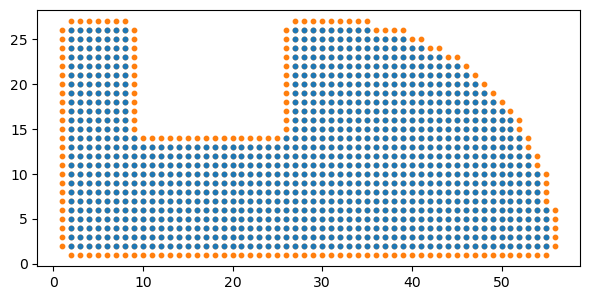

In [154]:
vary_size = 15



i = 100
r = 26
L = 29
width = 2 + vary_size
pos = 19-vary_size

nbands = int(200)


parameters = dict(
    r = r,
    L = L,
    width = width,
    pos = pos,
    Nx = L+r+3,
    Ny = r+3,
    theta = -(pi/2)*(i/100),
)

boundary_points, normal_angles, spinup_shape, spindown_shape, indices_to_delete = generate_quarter_stadium_indent(r,L,pos,width,plot_shape = True)

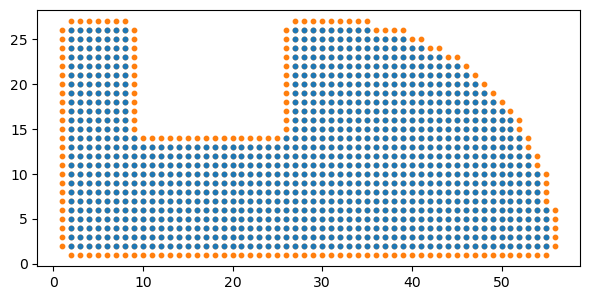

In [155]:
energies, states_shaped, degenerate_indices = solve_eigenproblem_stadium_indent(parameters, number_of_bands = nbands, plot_shape = True)

/tmp/ipykernel_25327/2632086788.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize = (3,3))


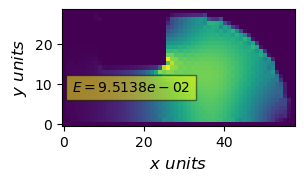

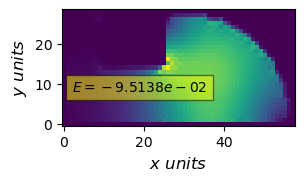

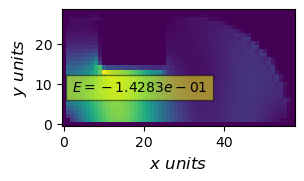

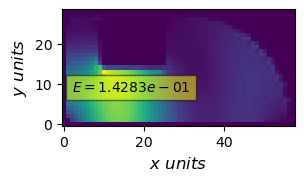

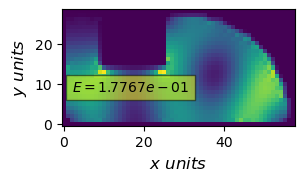

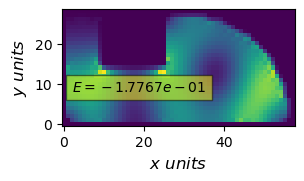

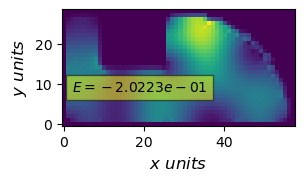

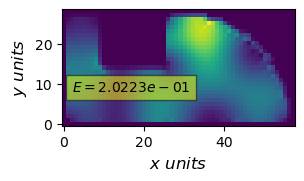

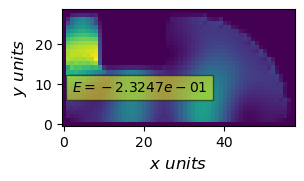

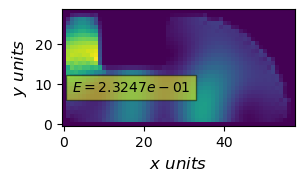

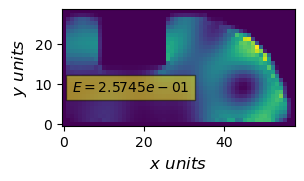

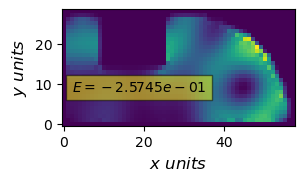

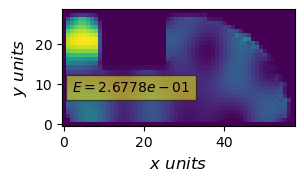

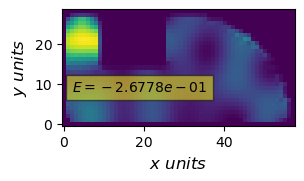

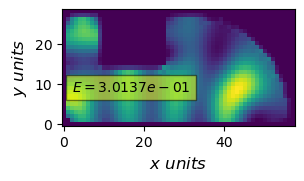

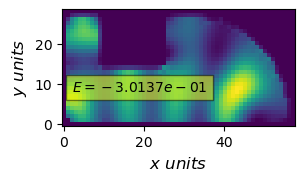

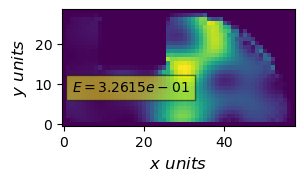

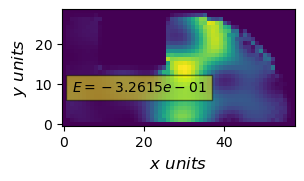

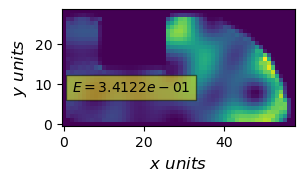

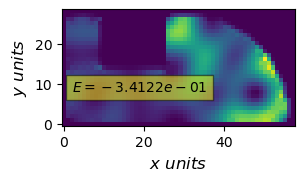

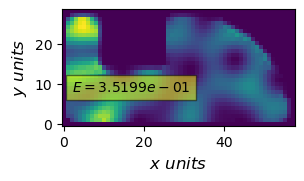

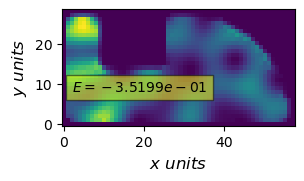

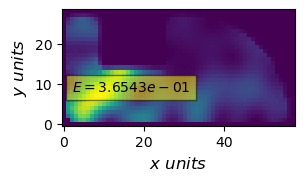

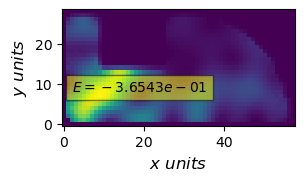

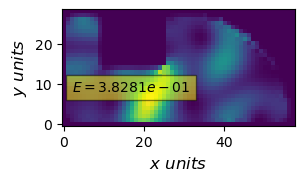

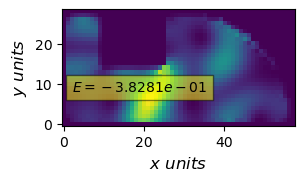

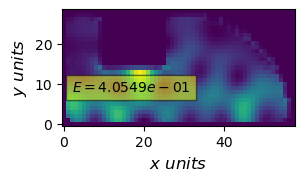

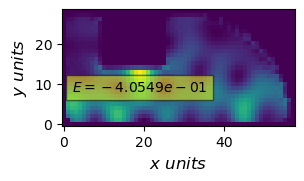

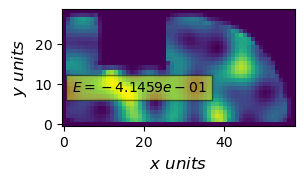

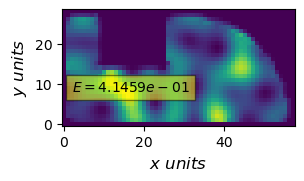

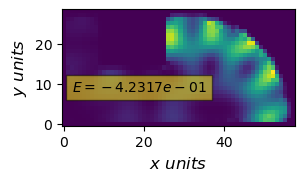

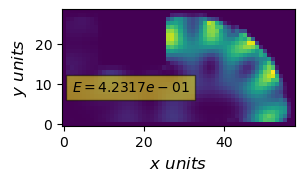

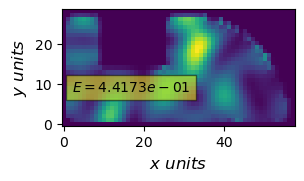

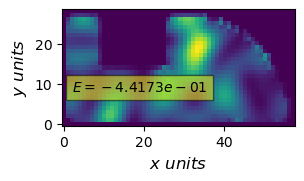

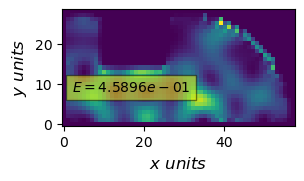

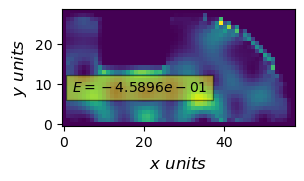

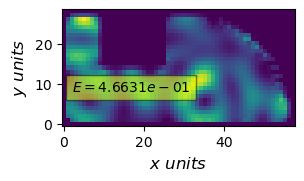

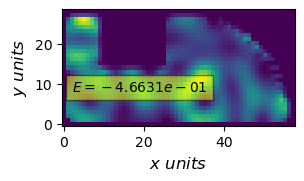

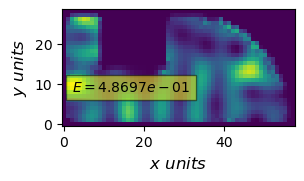

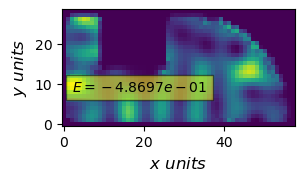

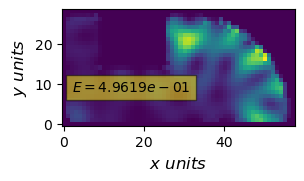

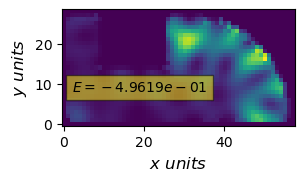

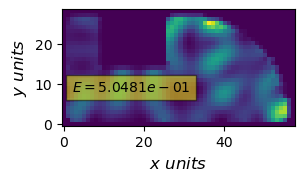

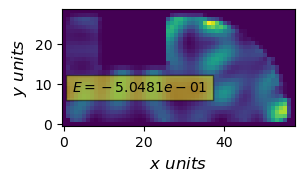

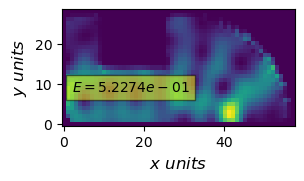

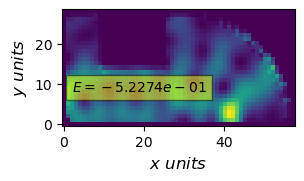

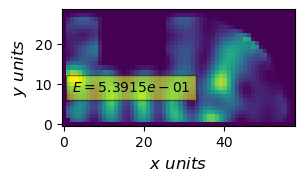

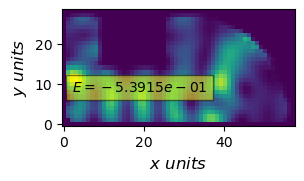

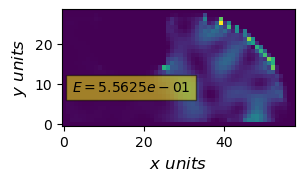

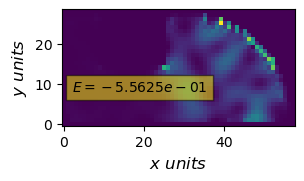

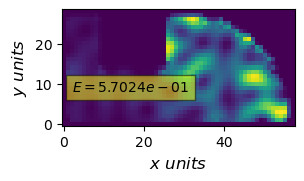

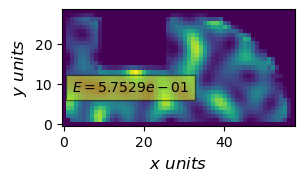

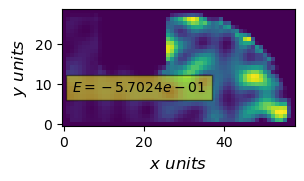

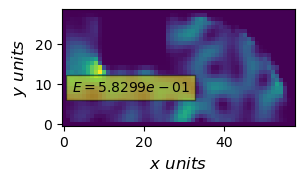

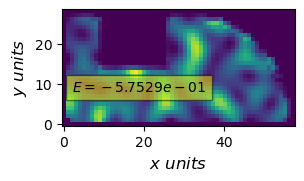

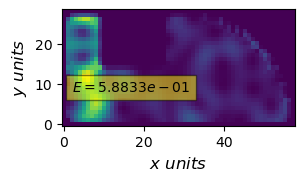

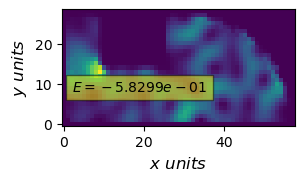

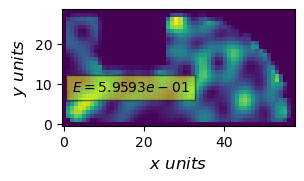

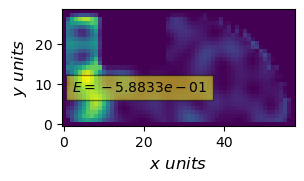

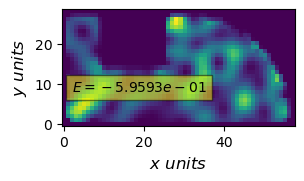

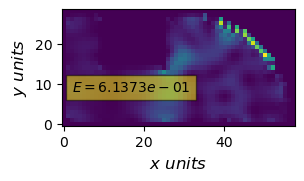

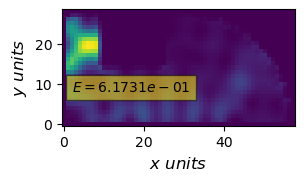

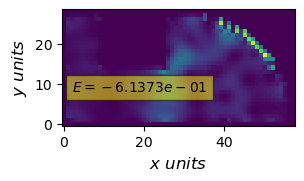

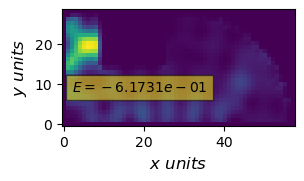

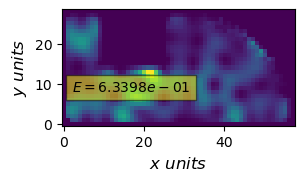

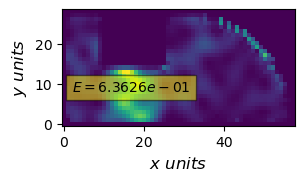

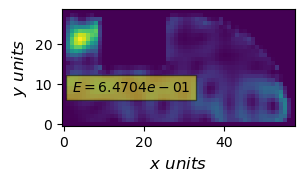

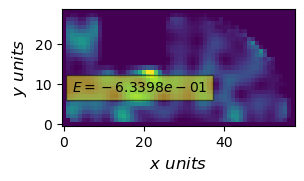

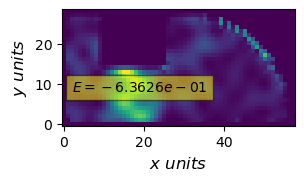

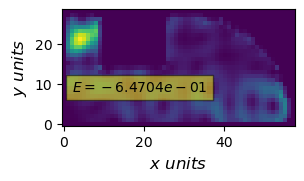

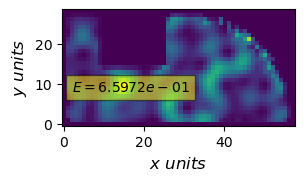

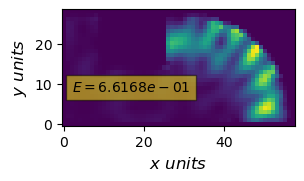

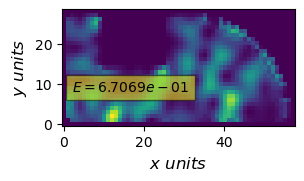

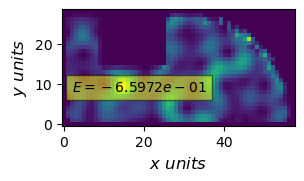

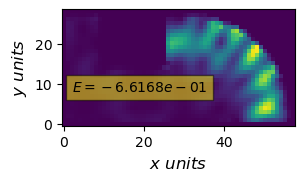

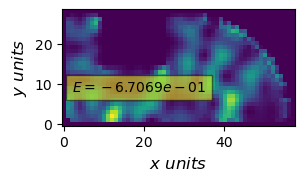

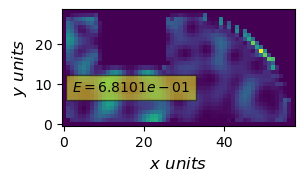

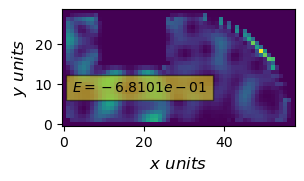

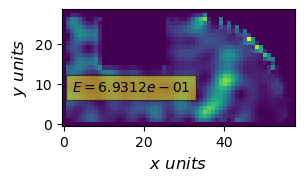

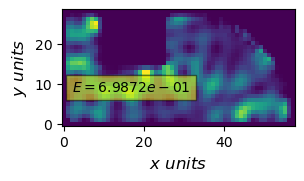

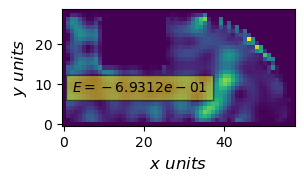

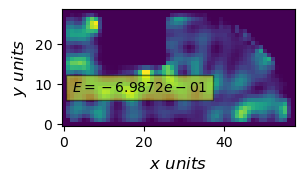

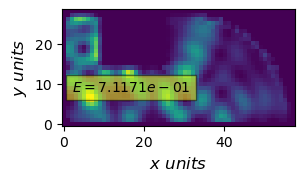

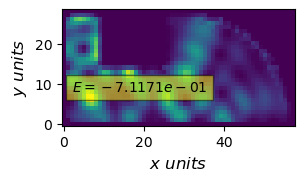

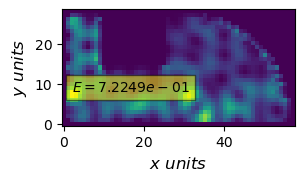

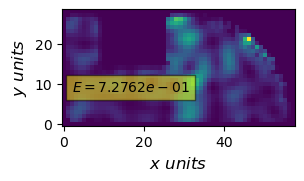

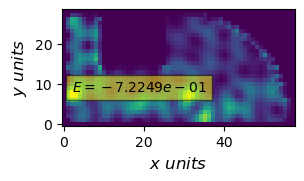

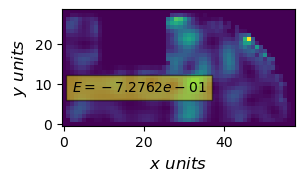

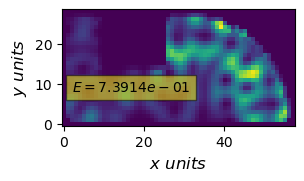

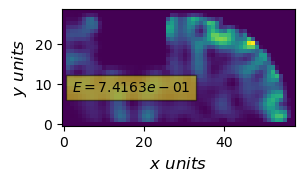

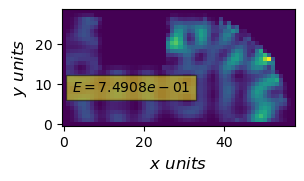

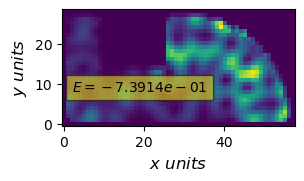

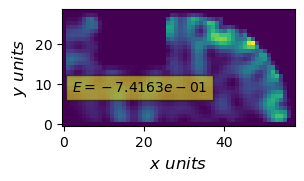

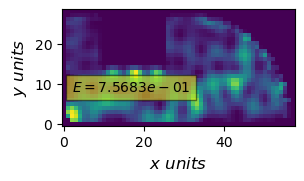

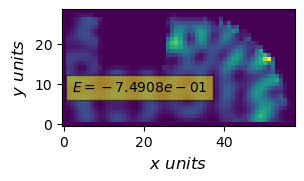

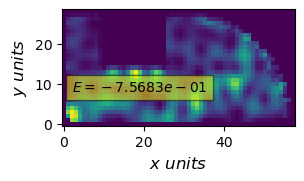

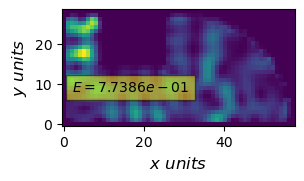

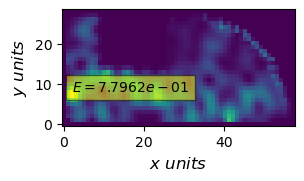

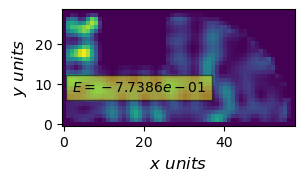

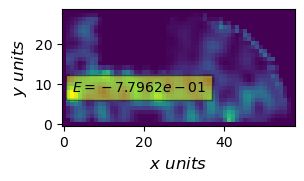

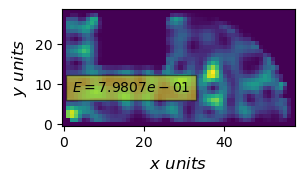

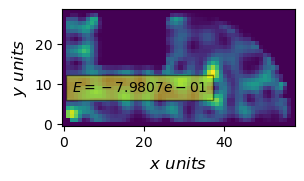

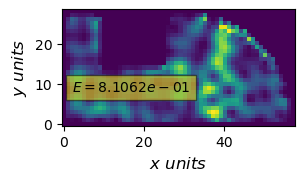

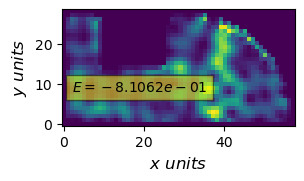

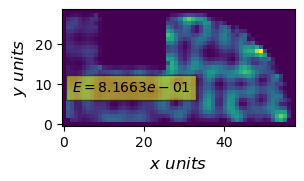

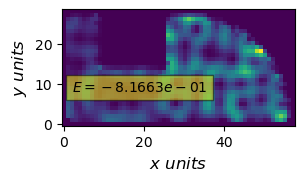

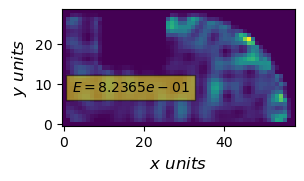

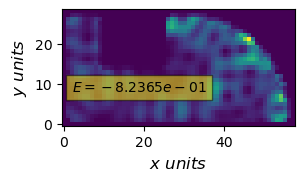

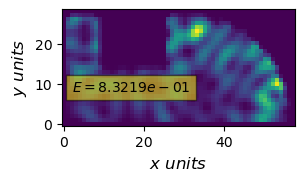

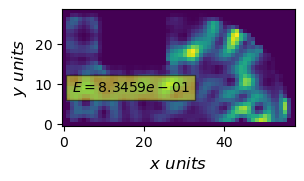

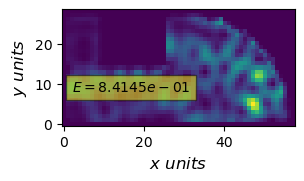

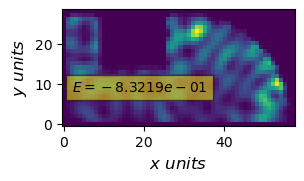

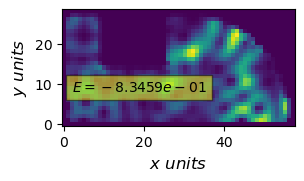

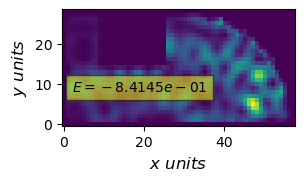

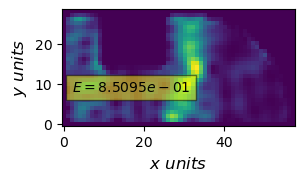

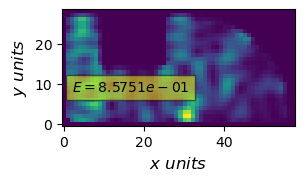

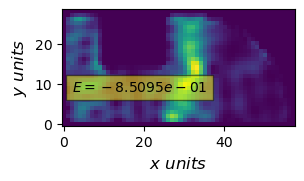

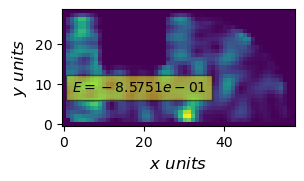

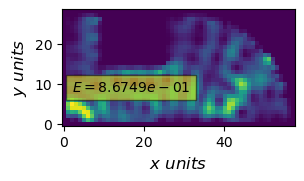

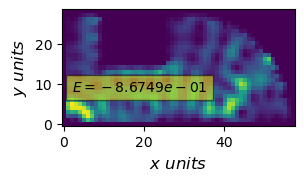

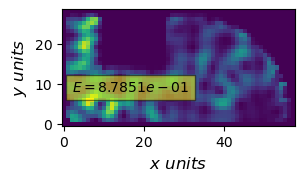

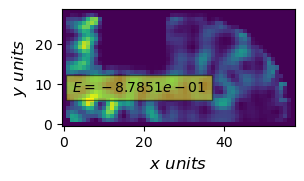

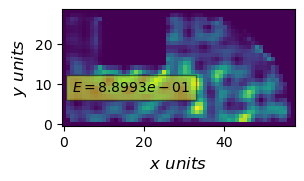

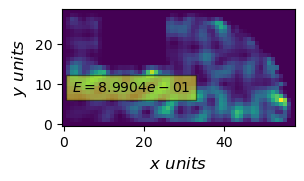

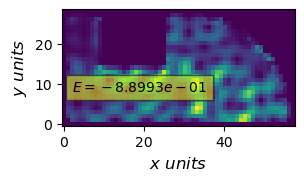

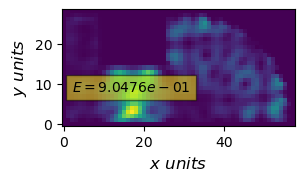

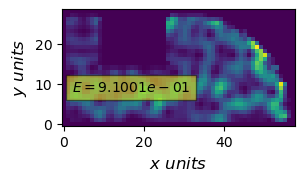

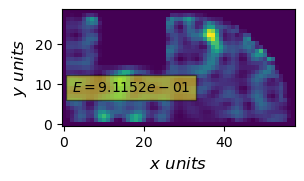

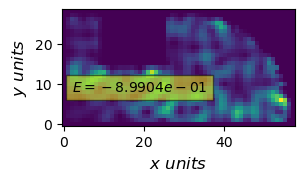

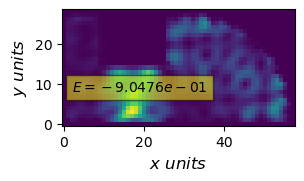

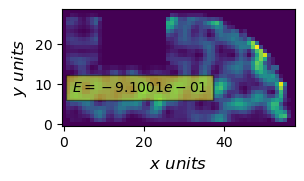

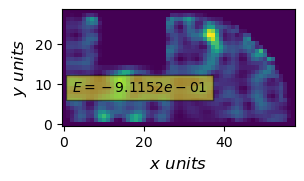

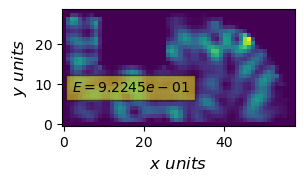

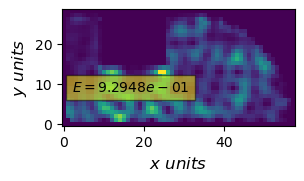

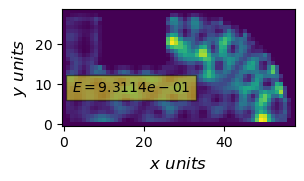

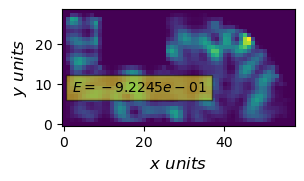

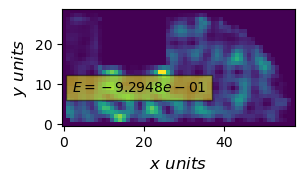

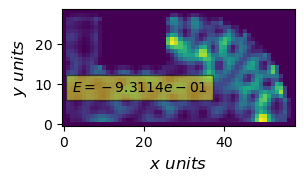

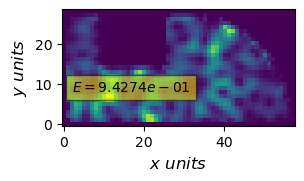

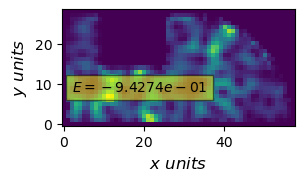

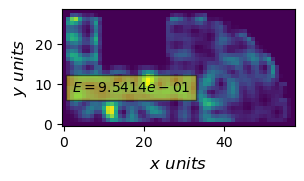

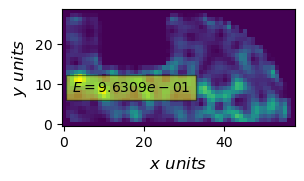

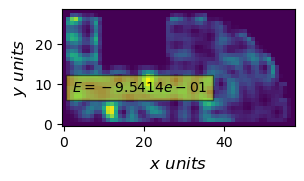

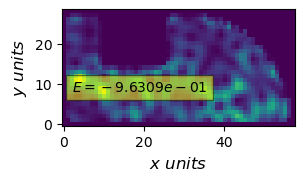

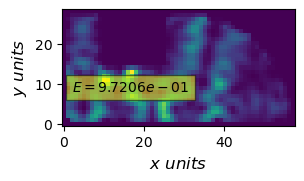

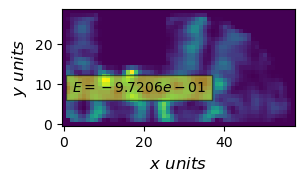

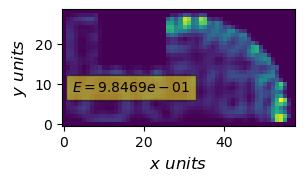

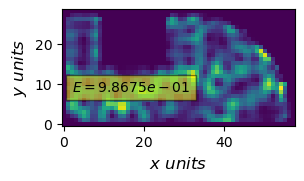

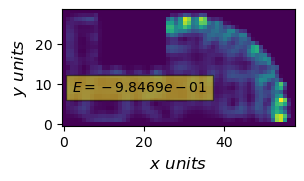

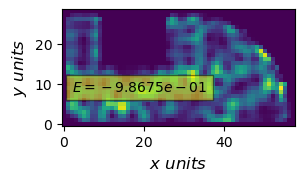

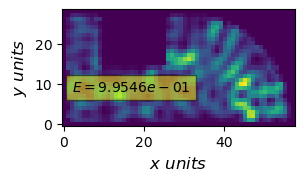

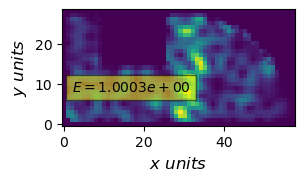

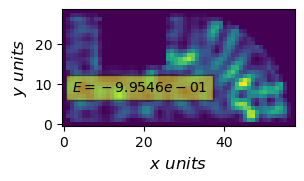

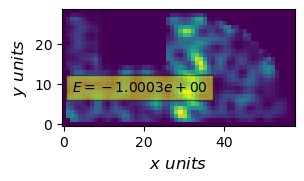

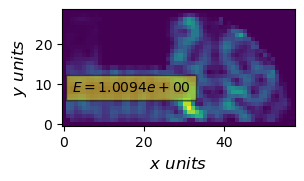

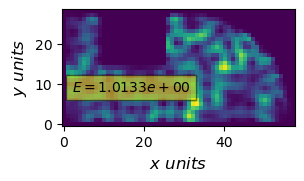

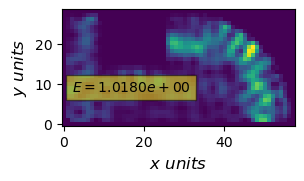

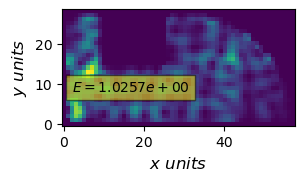

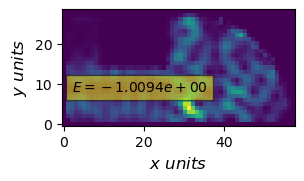

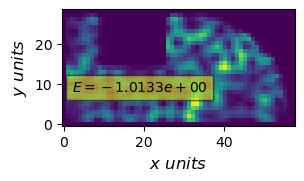

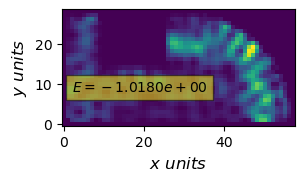

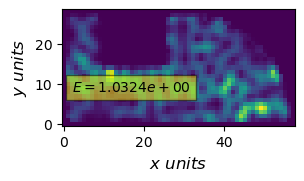

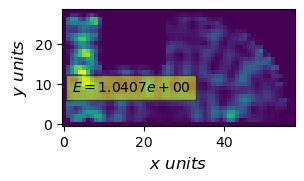

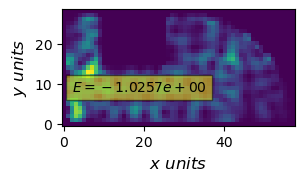

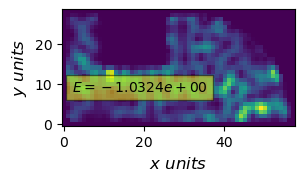

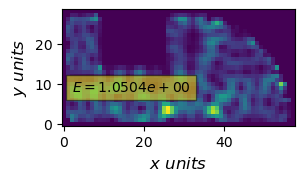

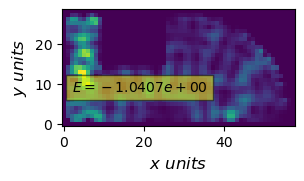

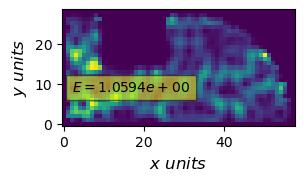

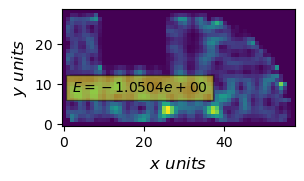

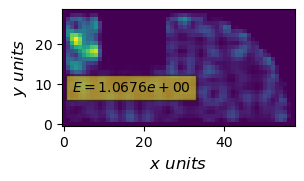

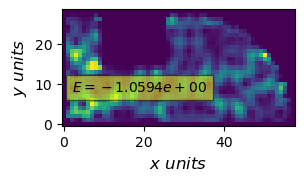

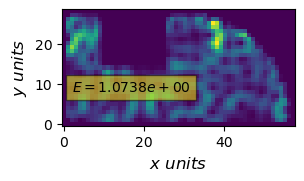

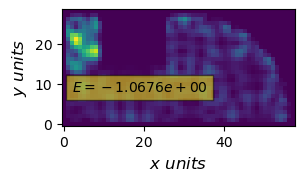

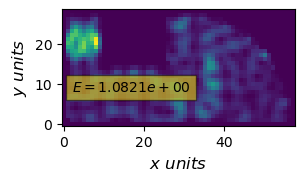

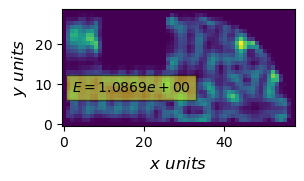

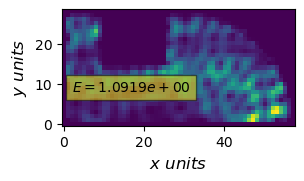

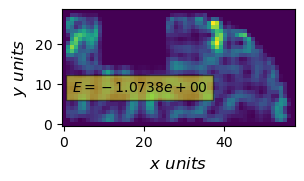

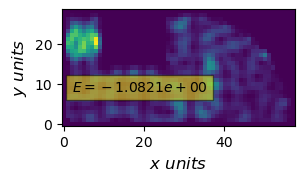

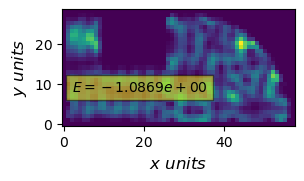

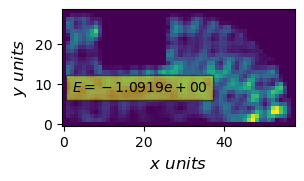

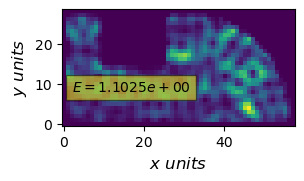

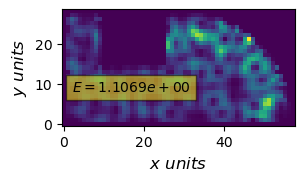

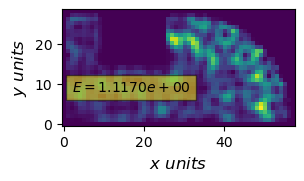

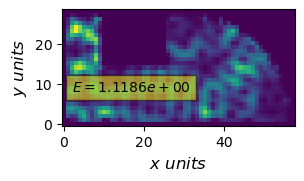

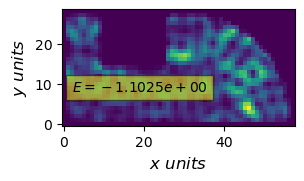

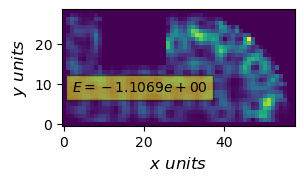

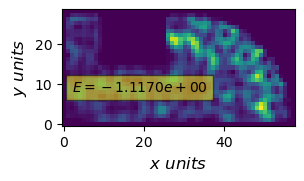

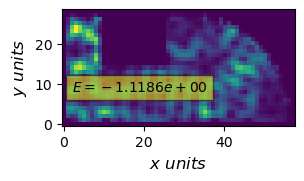

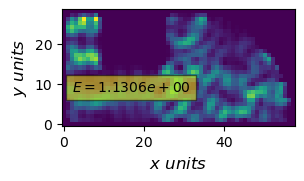

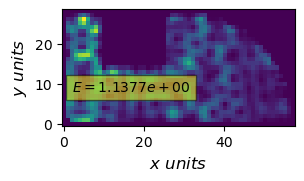

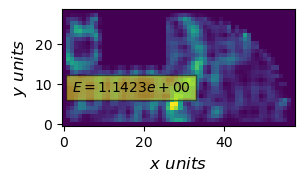

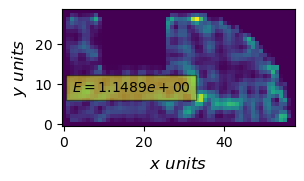

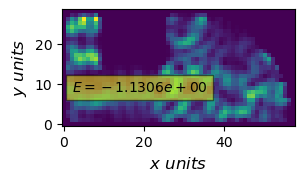

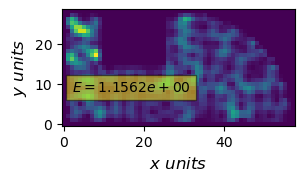

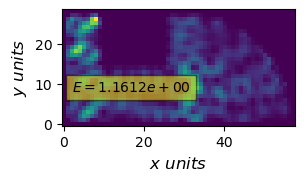

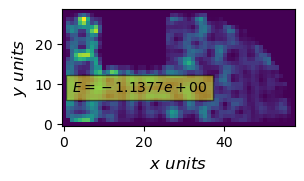

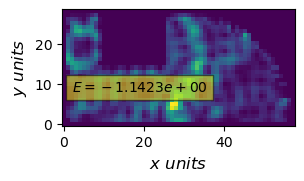

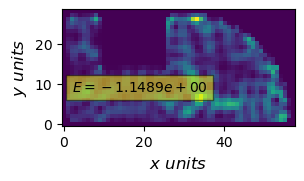

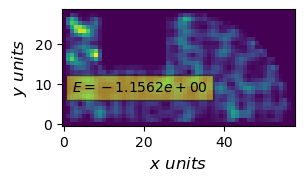

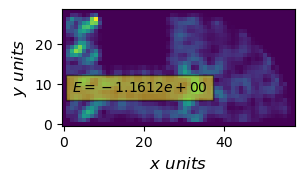

In [156]:
for i in range(nbands):
    to_plot = states_shaped[i,:,:,:]

    fig = plt.figure(figsize = (3,3))
    ax = fig.add_subplot(111)
    
    ax.imshow(np.sum(np.abs(to_plot)**2,axis = 0),vmin = 0, origin = "lower")
    #ax.imshow(np.abs(to_plot[1])**2,vmin = 0,cmap = 'cividis') This would plot only spin down probability density
    formatted_number = f"{energies[i]:.4e}"
    plt.text(2, 8,rf'$E ={formatted_number}$' , fontsize=10, bbox=dict(facecolor='yellow', alpha=0.5))
    
    ax.set_ylabel(r"$y$ $units$",fontsize = 12)
    ax.set_xlabel(r"$x$ $units$",fontsize = 12)


(-1.1612235411849103, 1.1612235411849032)

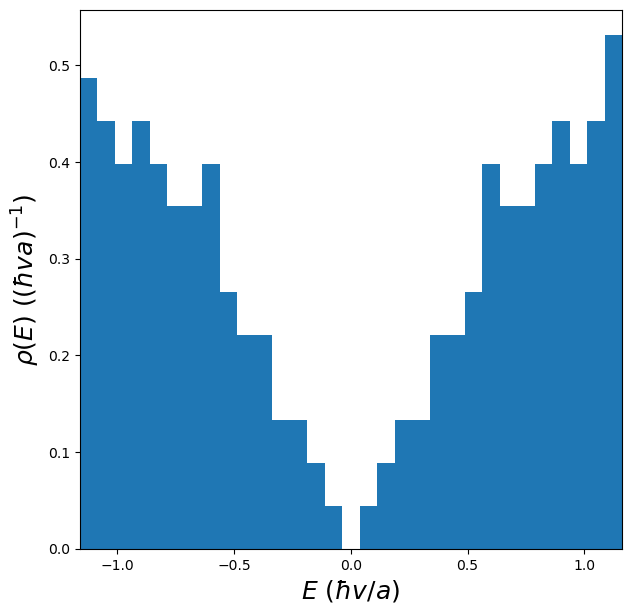

In [157]:
nbins = 31

stadium_DOS, bin_edges_stadium_DOS = np.histogram(energies, bins = nbins, range = (-max(energies),max(energies)), density = False)

area_stadium = (pi*(parameters['Ny']//2-1)**2 + 4*(parameters['Ny']//2-1)*(parameters['Nx']//2-1-parameters['Ny']//2-1))/4
x = (bin_edges_stadium_DOS[1:]+bin_edges_stadium_DOS[:-1])/2
dx = (bin_edges_stadium_DOS[1]-bin_edges_stadium_DOS[0])

fig_stadium_DOS = plt.figure(figsize = (7,7))
ax_stadium_DOS = fig_stadium_DOS.add_subplot(111)
ax_stadium_DOS.bar(x,stadium_DOS/dx/area_stadium,width = dx)
ax_stadium_DOS.set_ylabel(r"$\rho(E)$ ($(\hbar v a)^{-1}$)",fontsize = 18)
ax_stadium_DOS.set_xlabel(r"$E$ ($\hbar v/a$)",fontsize = 18)
ax_stadium_DOS.set_xlim(min(energies),max(energies))

/tmp/ipykernel_25327/134453146.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_25327/2537088281.py:149: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize = (7,7))


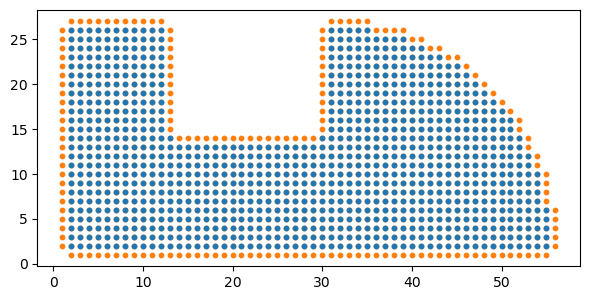

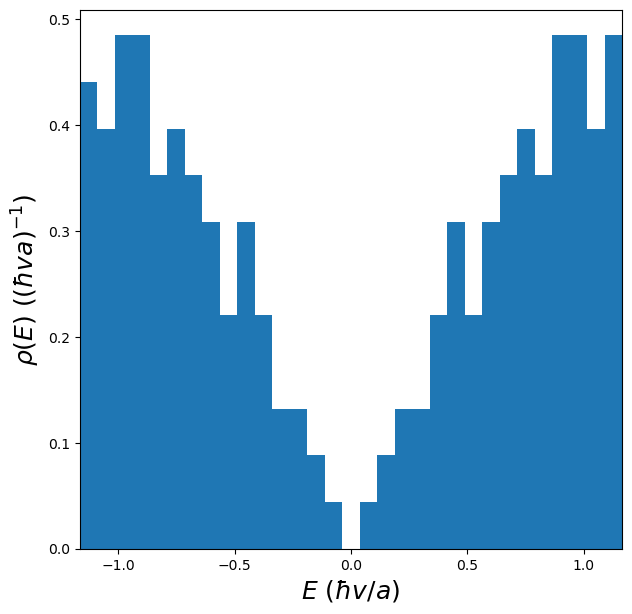

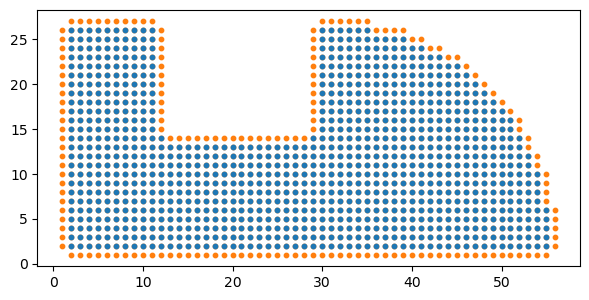

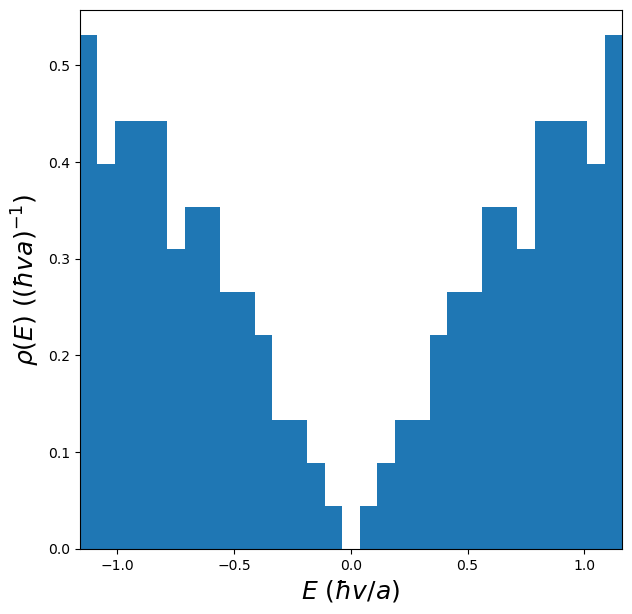

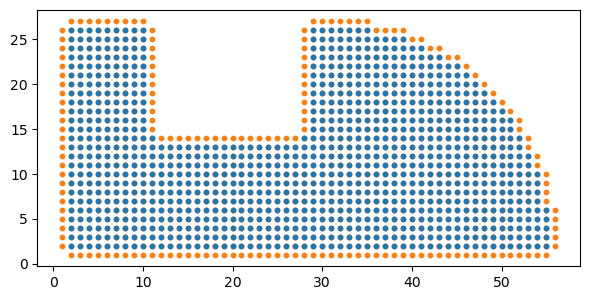

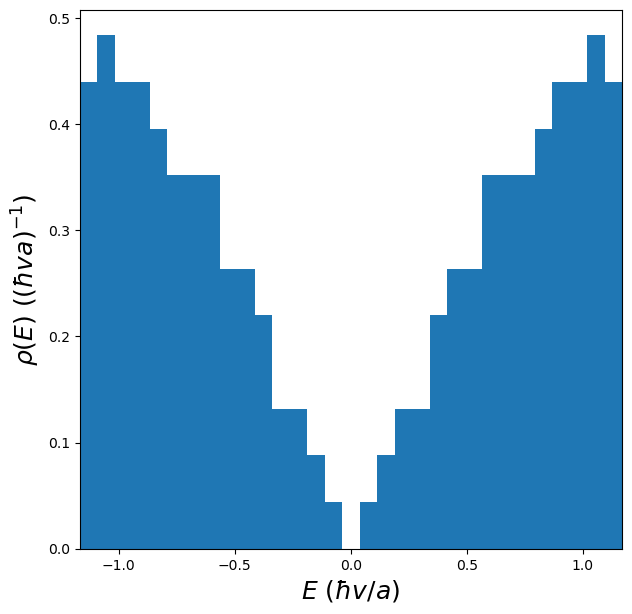

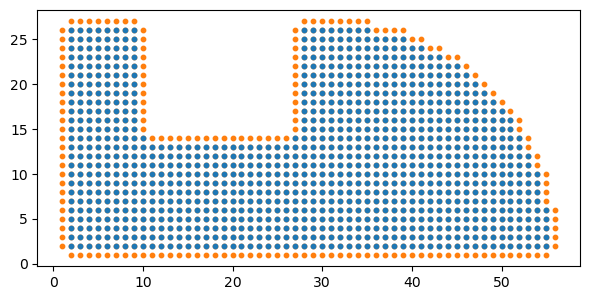

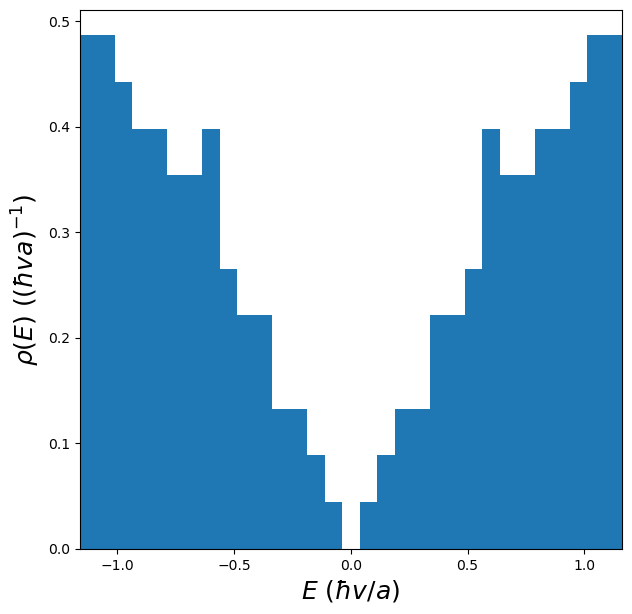

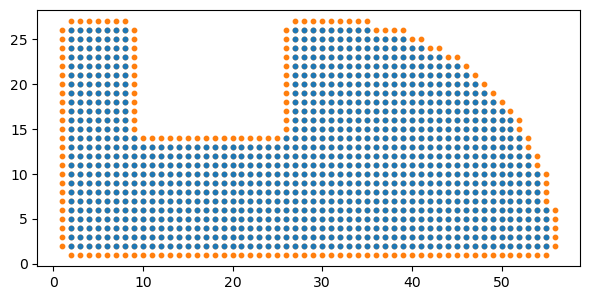

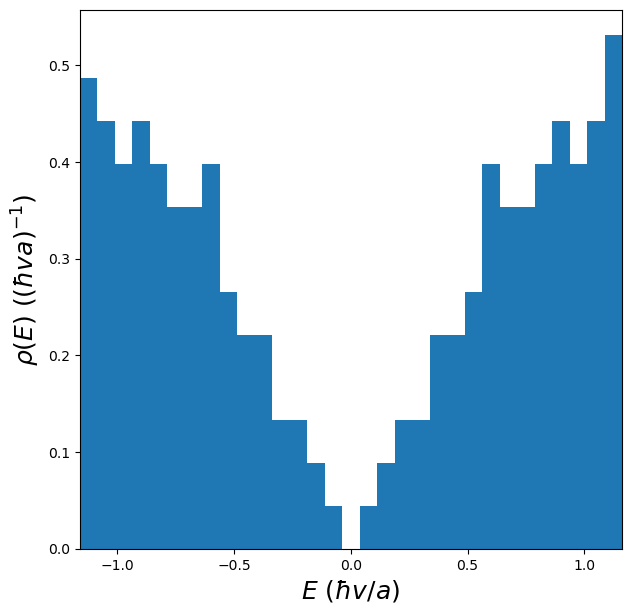

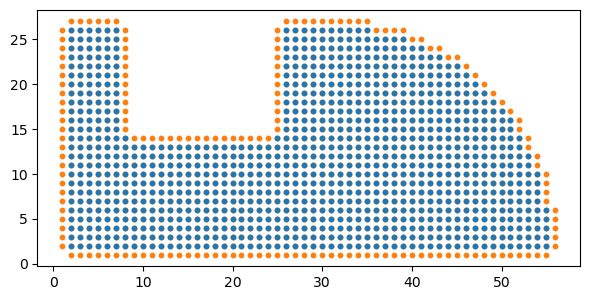

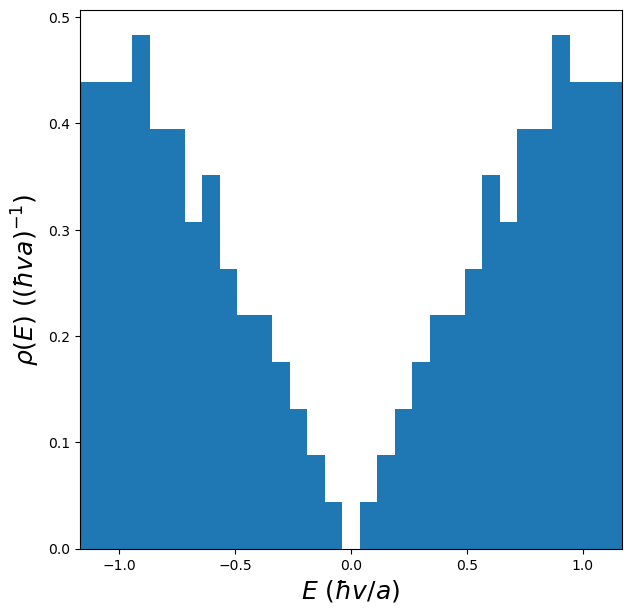

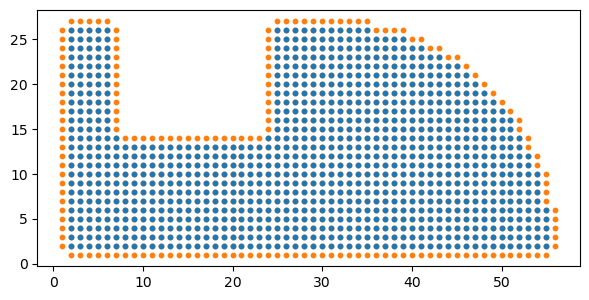

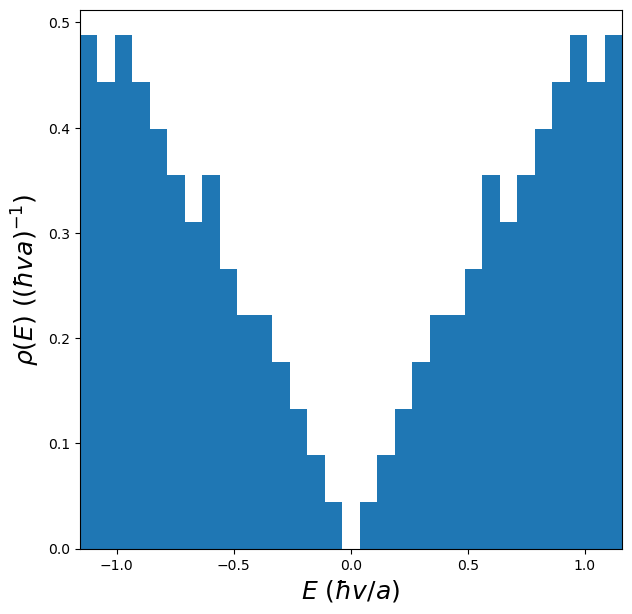

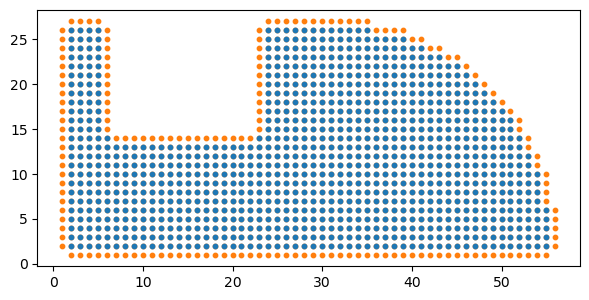

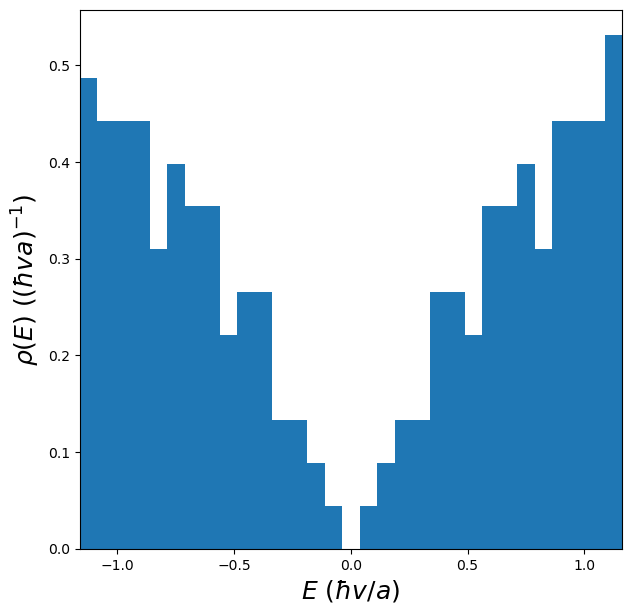

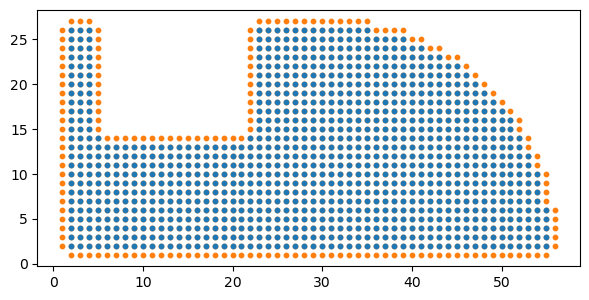

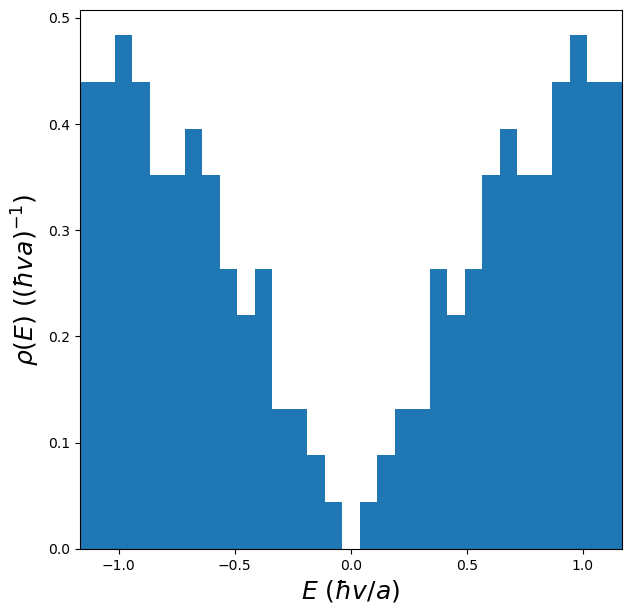

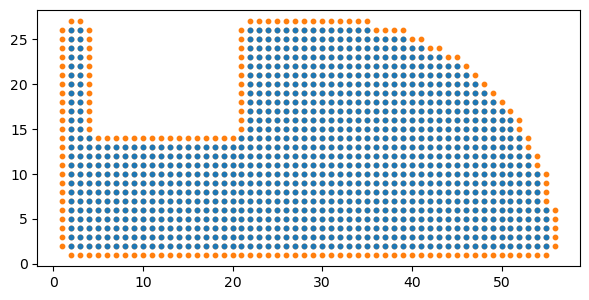

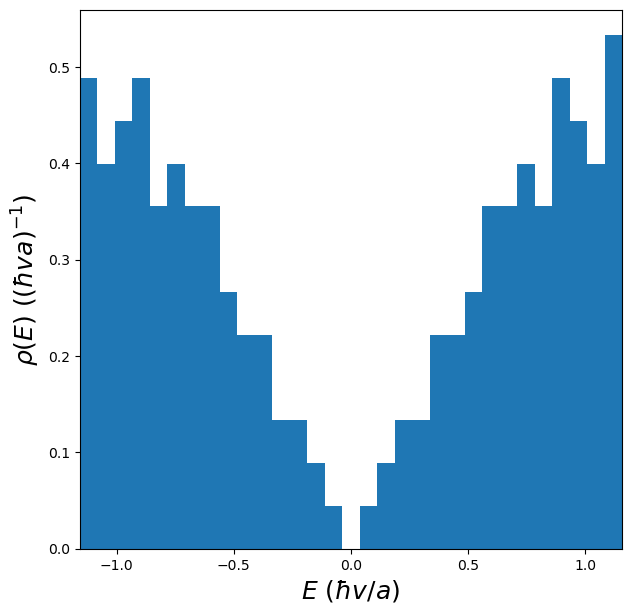

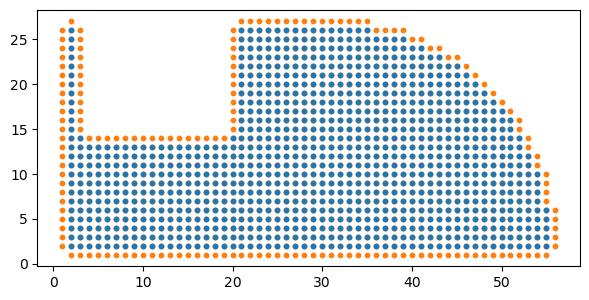

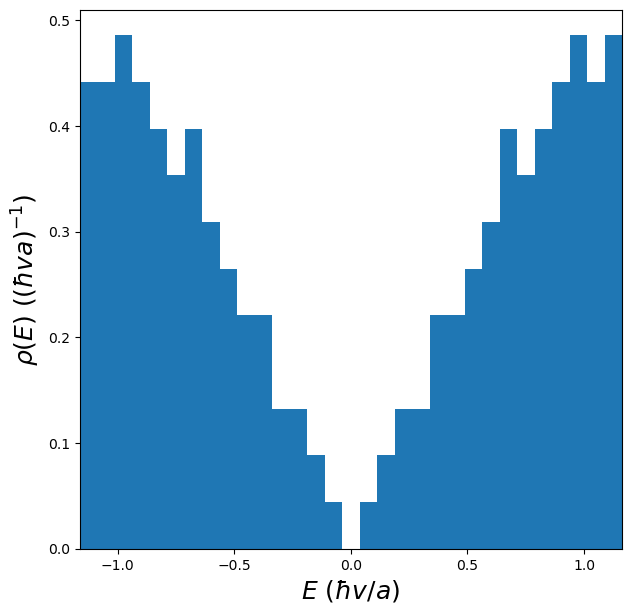

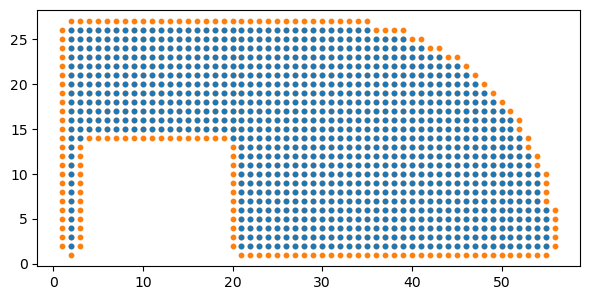

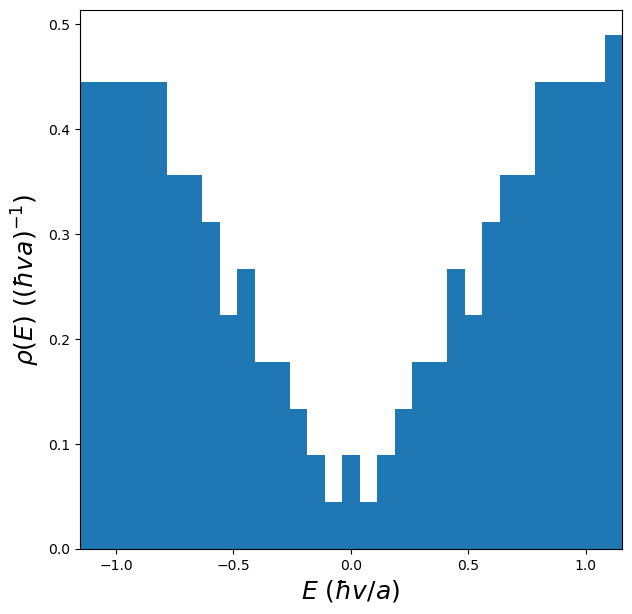

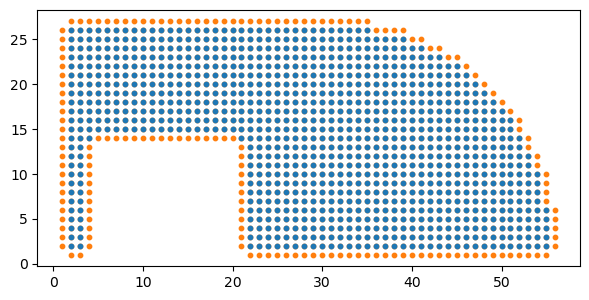

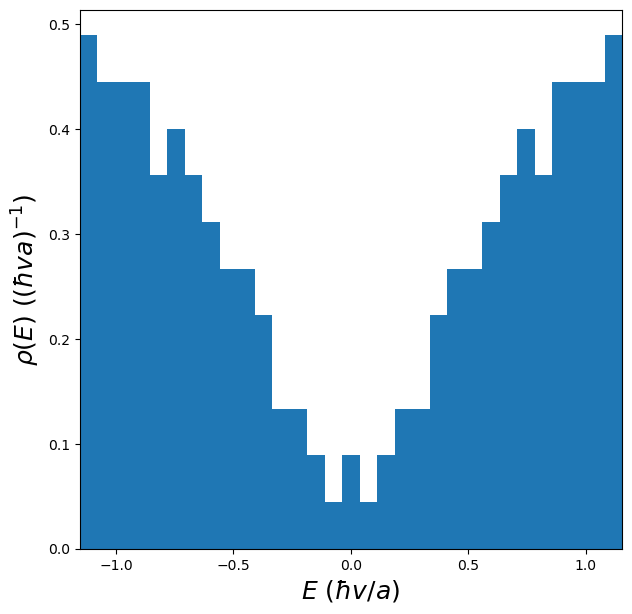

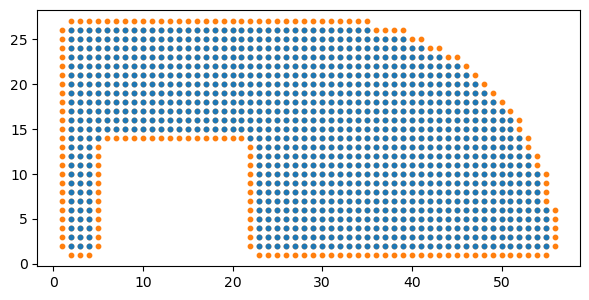

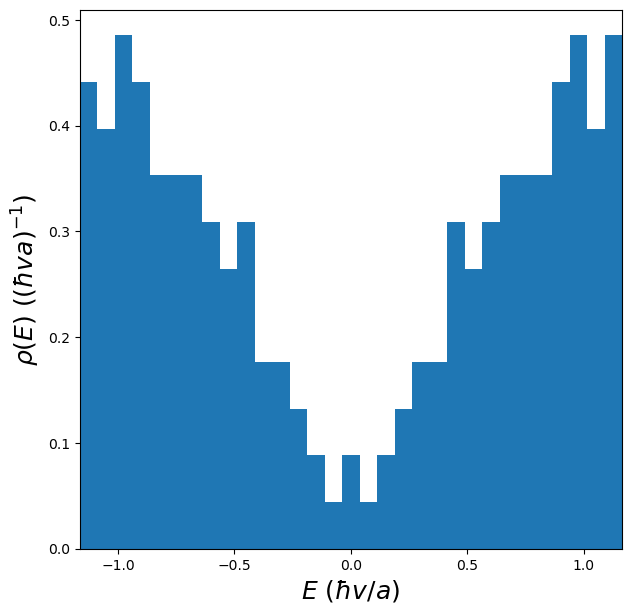

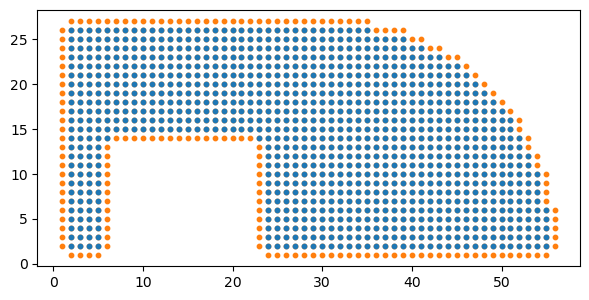

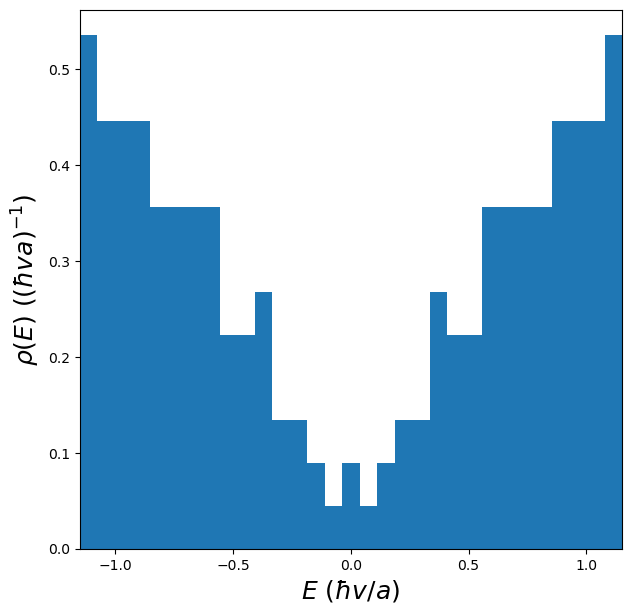

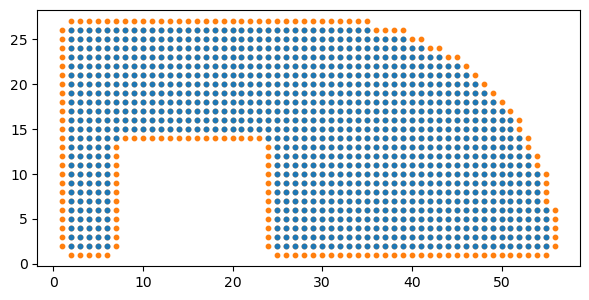

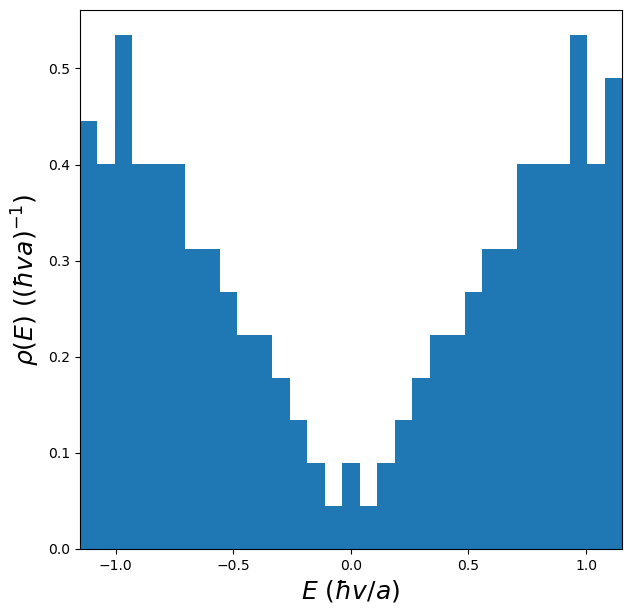

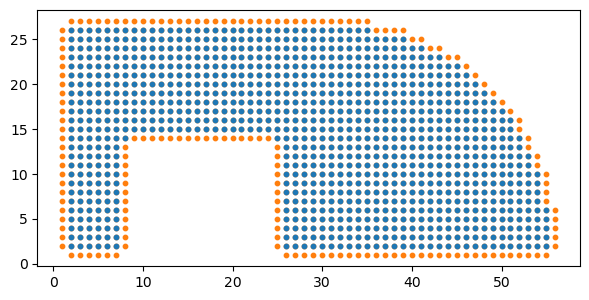

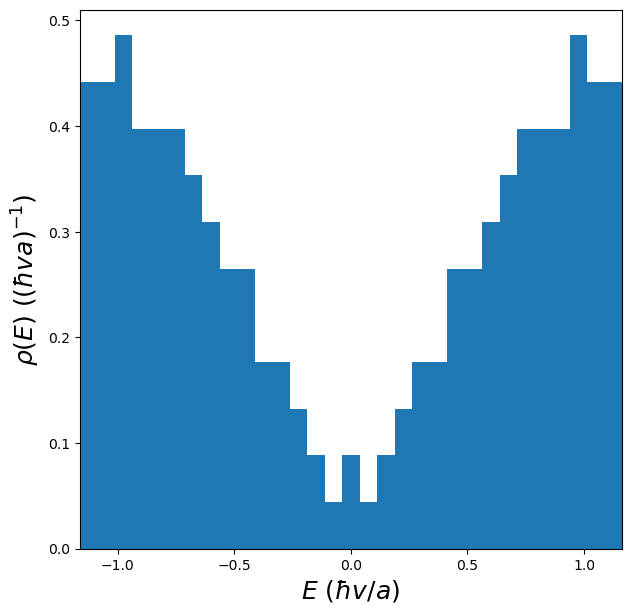

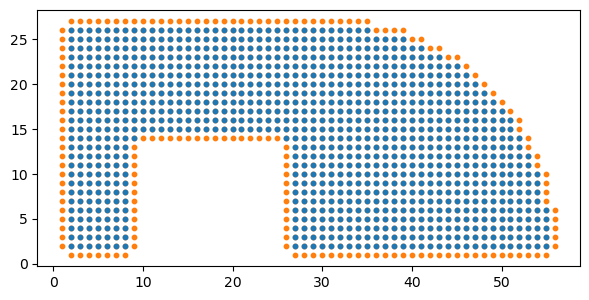

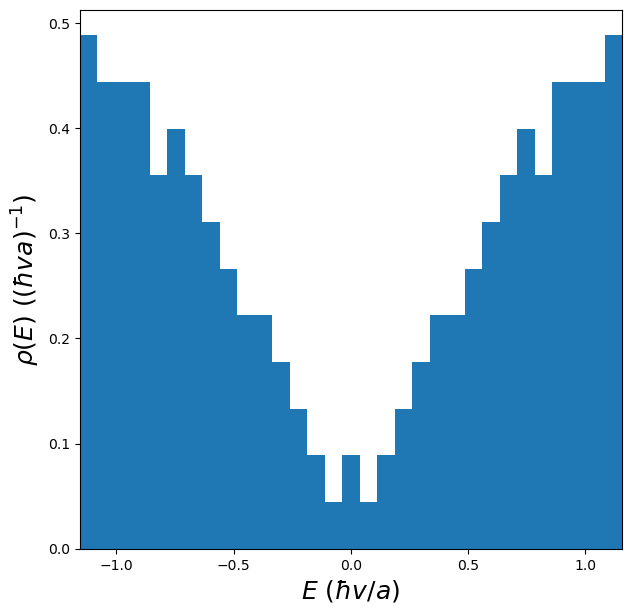

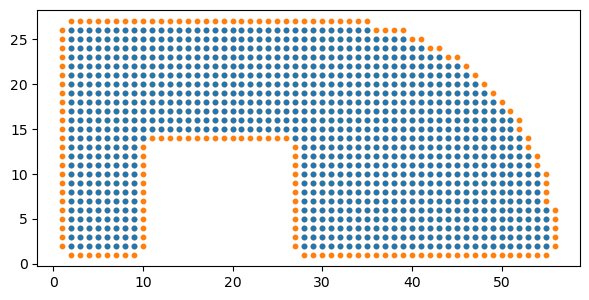

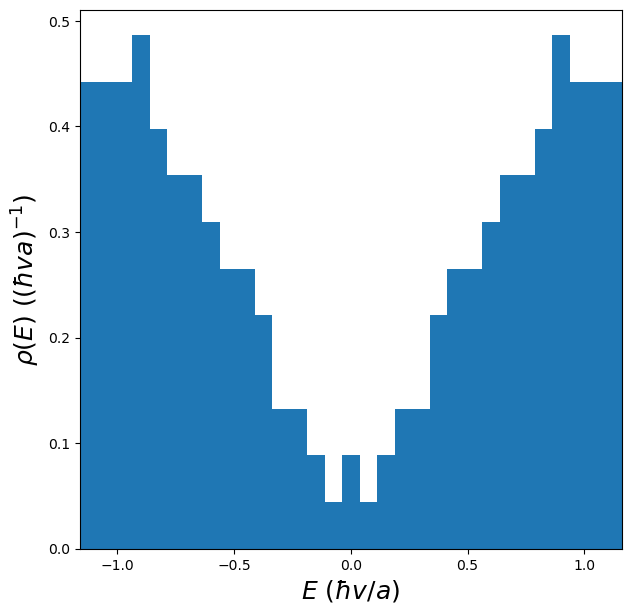

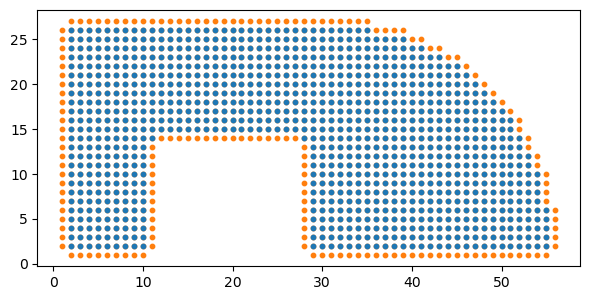

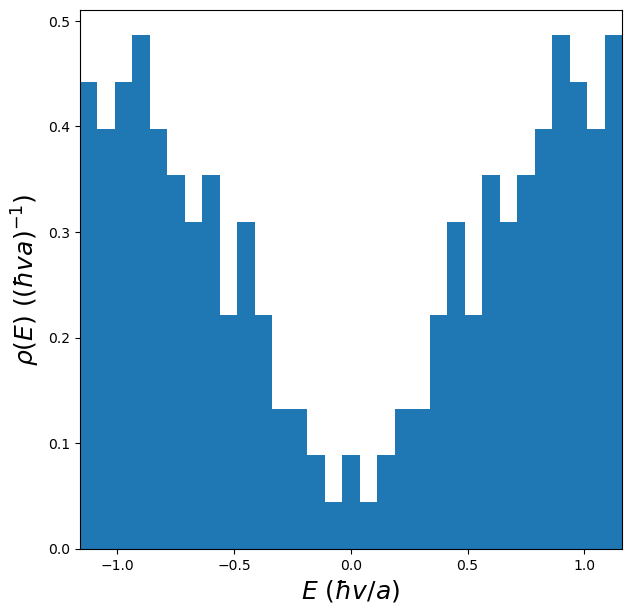

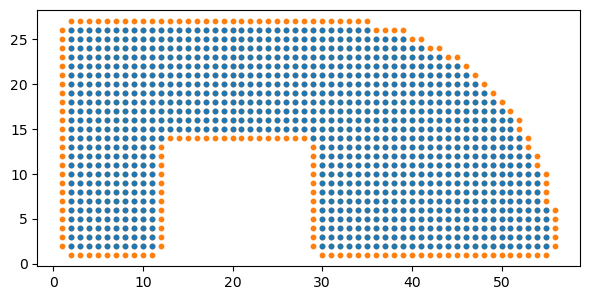

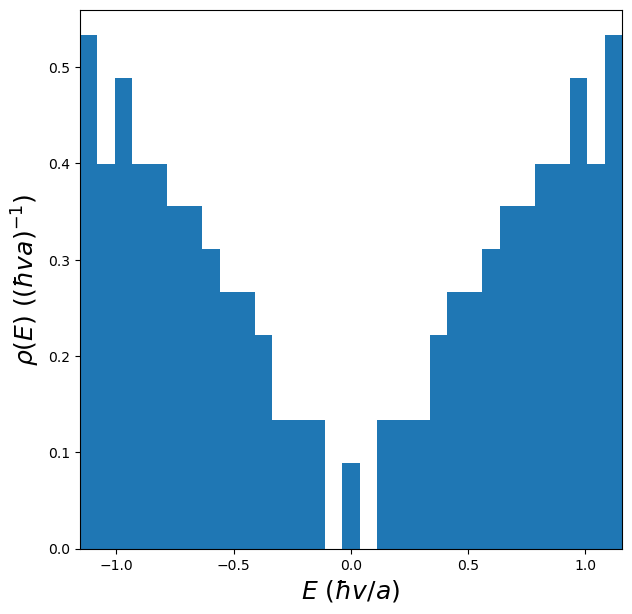

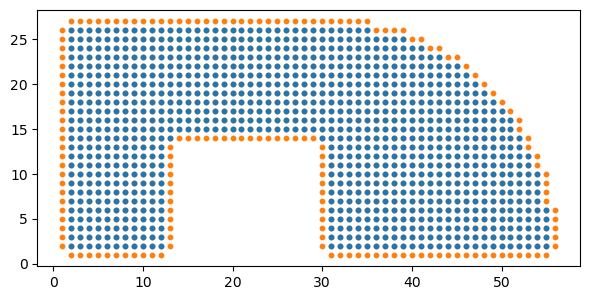

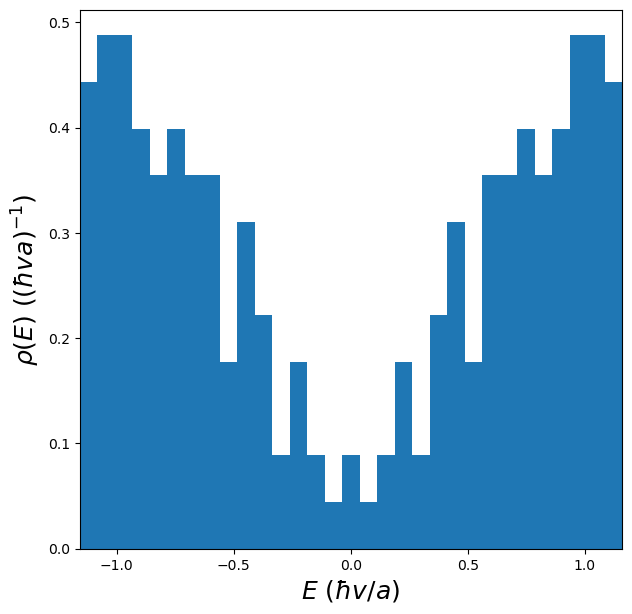

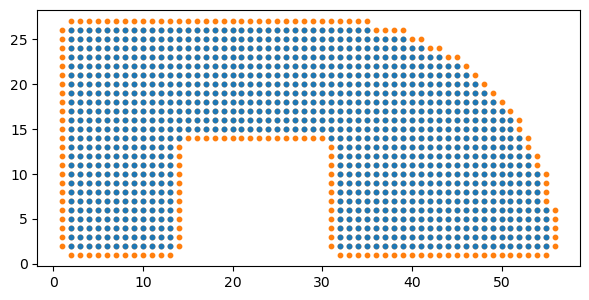

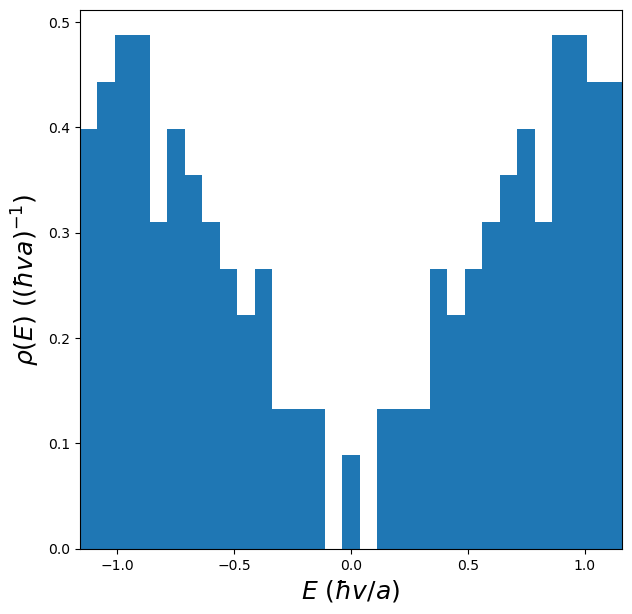

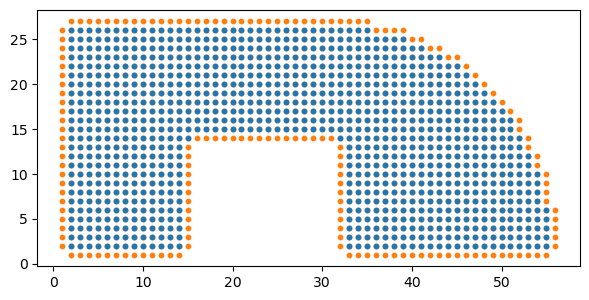

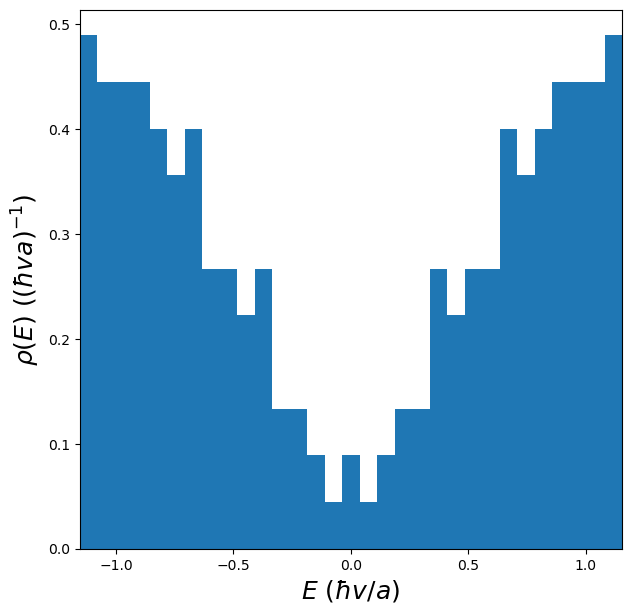

In [161]:
for pos in range(2*(L-width)):
    parameters['pos'] = pos
    energies, states_shaped, degenerate_indices = solve_eigenproblem_stadium_indent(parameters, number_of_bands = nbands, plot_shape = True)
    nbins = 31

    stadium_DOS, bin_edges_stadium_DOS = np.histogram(energies, bins = nbins, range = (-max(energies),max(energies)), density = False)
    
    area_stadium = (pi*(parameters['Ny']//2-1)**2 + 4*(parameters['Ny']//2-1)*(parameters['Nx']//2-1-parameters['Ny']//2-1))/4
    x = (bin_edges_stadium_DOS[1:]+bin_edges_stadium_DOS[:-1])/2
    dx = (bin_edges_stadium_DOS[1]-bin_edges_stadium_DOS[0])
    
    fig_stadium_DOS = plt.figure(figsize = (7,7))
    ax_stadium_DOS = fig_stadium_DOS.add_subplot(111)
    ax_stadium_DOS.bar(x,stadium_DOS/dx/area_stadium,width = dx)
    ax_stadium_DOS.set_ylabel(r"$\rho(E)$ ($(\hbar v a)^{-1}$)",fontsize = 18)
    ax_stadium_DOS.set_xlabel(r"$E$ ($\hbar v/a$)",fontsize = 18)
    ax_stadium_DOS.set_xlim(min(energies),max(energies))

    fig.show()